In [9]:
  # Import libraries
import math
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import scikitplot as skplt

from plotly.offline import iplot

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from tensorflow import keras
from tensorflow.keras import initializers, layers

## Load dataset relating items and skills

In [2]:
datas = list()
originals = list()
masks = list()

for i in range(100):
    data = pd.read_csv('output_data/10_missing/y/Y_rep' + str(i+1) + '_transformer_10_missing.csv', sep=';', header=None)
    data_train = np.ones(data.shape)
    data_train[data < 0.5] = 0.
    datas.append(data_train)
    original = pd.read_csv('input_data/y/Yrep' + str(i+1) + '.csv', sep=';', header=None)
    originals.append(original.values.reshape((90, 10000)).transpose()[:8000, :])
    masks.append(pd.read_csv('output_data/10_missing/masked/Masked_rep' + str(i+1) + '_10_missing.csv', sep=';', header=None))


In [3]:
Q = pd.read_csv('input_data/qmatrix/Qmatrix.csv', sep=';', header=None)
Q = Q.T
print(Q.shape)

(21, 90)


In [4]:
for d, m, o in zip(datas, masks, originals):

    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if m.iloc[i, j] != -1 and d[i, j] != o[i, j]:
                d[i, j] = o[i, j]

In [5]:
print(datas)

[array([[1., 0., 1., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]]), array([[0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]]), array([[1., 0., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]]), array([[1., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]]), array([[1., 1., 1., ..., 0., 0.

In [6]:
# Set stats and skills
num_stats = datas[0].shape[1] 
num_skills = 21

intermediate_dim=40

# Number of subjects
N = datas[0].shape[0]
# Training number
tr = N
batch_size = 50
epochs = 100

In [7]:
""" Helper functions """

# Restrict connection in decoder
def q_constraint(w):
    target = w * Q
    diff = w - target
    w = w * tf.cast(tf.math.equal(diff, 0), keras.backend.floatx()) 
    return w * tf.cast(tf.math.greater_equal(w, 0), keras.backend.floatx())

# Remove zeros function
def remove_zeros(arr):
  n_arr = []
  
  for j in range(num_skills): 
    for i in range(num_stats):
      if Q.iloc[j, i] != 0:
        n_arr.append(arr[j][i])
  
  return n_arr


In [8]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
  
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(keras.Model):
    """Maps items respone to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=num_skills, intermediate_dim=intermediate_dim, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="tanh")
        self.dense_mean = layers.Dense(latent_dim
                                       #, kernel_initializer=initializers.Zeros()
                                       )
        self.dense_log_var = layers.Dense(latent_dim
                                          #, kernel_initializer=initializers.Zeros()
                                          )
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        #tf.print(tf.math.reduce_mean(z_mean))
        z_log_var = self.dense_log_var(x)
        #tf.print(tf.math.reduce_mean(tf.math.exp(0.5 * z_log_var)))

        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(keras.Model):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, latent_dim=num_skills, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        #self.dense_proj = layers.Dense(latent_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim
                                         , activation="sigmoid"
                                         , kernel_constraint=q_constraint
                                         #, kernel_initializer=initializers.Ones()
                                         #, bias_initializer=initializers.Zeros()
                                         )

    def call(self, inputs):
        #x = self.dense_proj(inputs)
        return self.dense_output(inputs)



class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=intermediate_dim,
        latent_dim=num_skills,
        name="autoencoder"
    ):
        super(VariationalAutoEncoder, self).__init__(name=name)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, latent_dim=latent_dim)

    def call(self, inputs):
        self.z_mean, self.z_log_var, self.z = self.encoder(inputs)
        reconstructed = self.decoder(self.z)
        return reconstructed

    # Loss function
    def vae_loss(self, input, output):
        cross_entropy_loss = (num_stats / 1.0) * keras.losses.binary_crossentropy(input, output)
        kl_loss = -0.5 * tf.reduce_mean(self.z_log_var - tf.square(self.z_mean) - tf.exp(self.z_log_var) + 1, axis=-1)
        return cross_entropy_loss + kl_loss

    # Get weights
    def _get_weights(self):
        return self.decoder.trainable_weights

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

In [10]:
thetas = pd.DataFrame()
thetas_logvar = pd.DataFrame()
discrs_hat = pd.DataFrame()
diffs = pd.DataFrame()
preds = pd.DataFrame()

start_time = time.time()
for i in range(100):
    
    vae_q = VariationalAutoEncoder(num_stats, intermediate_dim, num_skills)

    # Optimizer
    #opt = tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True)
    opt = tf.keras.optimizers.SGD(learning_rate=0.005)
    
    vae_q.compile(optimizer=opt, loss=vae_q.vae_loss, metrics=['binary_accuracy'])

    data_train = datas[i]
    
    history = vae_q.fit(data_train,
                        data_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        shuffle=True)
    # validation_split=0.2
    ba = 0
    for value in history.history['binary_accuracy']:
        ba += value
    print("Binary Accuracy: %.4f" % (ba / epochs))

    encoder = vae_q.get_encoder()
    decoder = vae_q.get_decoder()
    #weights = vae_q.get_decoder().trainable_weights

    weights = vae_q._get_weights()

    discr = weights[0].numpy()
    #print(discr.shape)
    #diff = pd.DataFrame(weights[3].numpy())
    negative_diff = pd.DataFrame(np.negative(weights[1].numpy()))

    # Get latent trait predictions
    thetas_hat, log_var_thetas_hat, z_pred = encoder.predict(data_train)
    pred = decoder.predict_step(z_pred)
    #print(pred)
    #print(thetas_hat)

    # Total score on the test -------
    score = np.apply_over_axes(np.sum, data_train, 1)

    #### Vectoring the matrices Thetas_hat ans discr ####
    theta_hat = np.transpose(thetas_hat).flatten()
    #step_theta_hat = np.transpose(step_thetas_hat.numpy()).flatten()
  
    log_var_theta_hat = np.transpose(log_var_thetas_hat).flatten()
    #step_log_var_theta_hat = np.transpose(step_log_var_thetas_hat.numpy()).flatten()

    discr_hat = remove_zeros(discr)

    # Save results
    theta_est_rep_GUI = pd.DataFrame({'Thetas Estimation': theta_hat, 'Log Var Thetas Estimation': log_var_theta_hat})
    theta_est_rep_GUI.to_csv('output_data/10_missing/theta/thetas_rep' + str(i+1) + '_transformer_10_missing.csv', sep=';', index=False)
    thetas['Rep' + str(i+1)] = theta_hat
    thetas_logvar['Rep' + str(i+1)] = log_var_theta_hat

    discr = pd.DataFrame(discr)
    discr.to_csv('output_data/10_missing/a/discr_rep' + str(i+1) + '_transformer_10_missing.csv', sep=';', header=None, index=False)

    discr_hat_GUI = pd.DataFrame([discr_hat])
    discr_hat_GUI.to_csv('output_data/10_missing/a/discr_hat_rep' + str(i+1) + '_transformer_10_missing.csv', sep=';', header=None, index=False)
    discrs_hat['Rep' + str(i+1)] = discr_hat

    # Save a estimated replication TRANSPOSED
    discr_hat_GUI.T.to_csv(
        'output_data/10_missing/a/discr_hat_rep' + str(i+1) + '_transformer_10_missing_TRANSPOSED.csv', sep=';', header=None, index=False)

    negative_diff.to_csv('output_data/10_missing/b/diff_rep' + str(i+1) + '_transformer_10_missing.csv', sep=';', header=None, index=False)
    diffs['Rep' + str(i+1)] = np.negative(weights[1].numpy())

    preds['Rep' + str(i+1)] = pred.numpy().flatten()

end_time = time.time()
print("total time taken this loop: ", end_time - start_time)

Epoch 1/100


2023-09-22 09:15:47.168171: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


160/160 [==============================] - 1s 591us/step - loss: 61.7429 - binary_accuracy: 0.5903
Epoch 2/100
160/160 [==============================] - 0s 539us/step - loss: 59.9269 - binary_accuracy: 0.6269
Epoch 3/100
160/160 [==============================] - 0s 530us/step - loss: 58.3454 - binary_accuracy: 0.6477
Epoch 4/100
160/160 [==============================] - 0s 628us/step - loss: 56.9649 - binary_accuracy: 0.6559
Epoch 5/100
160/160 [==============================] - 0s 537us/step - loss: 56.1252 - binary_accuracy: 0.6608
Epoch 6/100
160/160 [==============================] - 0s 542us/step - loss: 55.3552 - binary_accuracy: 0.6681
Epoch 7/100
160/160 [==============================] - 0s 535us/step - loss: 54.5414 - binary_accuracy: 0.6772
Epoch 8/100
160/160 [==============================] - 0s 526us/step - loss: 53.6500 - binary_accuracy: 0.6864
Epoch 9/100
160/160 [==============================] - 0s 520us/step - loss: 52.6898 - binary_accuracy: 0.6963
Epoch 10/100


In [11]:
binary_preds = np.ones(preds.shape)
binary_preds[preds.values < 0.5] = 0.

In [12]:
binary_preds = pd.DataFrame(binary_preds, columns=preds.columns)

In [13]:
# a artificial
a_values = pd.read_csv('input_data/a/a_values.csv', sep=';', header=None)
#a_rep_gui = pd.read_csv('output/discr_hat_transformer_10_missing_TRANSPOSED.csv', sep=';', header=0)

# b artificial
b_values = pd.read_csv('input_data/b/b_values.csv', sep=';', header=None)
#b_rep_gui = pd.read_csv('output/diff_transformer_10_missing.csv', sep=';', header=0)

# theta artificial
theta_values = pd.read_csv('input_data/theta/theta_values.csv', sep=';', header=None)
#theta_rep_gui = pd.read_csv('output/thetas_transformer_10_missing.csv', sep=';', header=0)

## Discriminations

In [14]:
cols = ['a_values']

a_results = pd.DataFrame(columns=cols)

a_results['a_values'] = a_values

a_results = pd.concat([a_results, discrs_hat], axis=1)

In [15]:
a_results['Bias'] = np.sum(a_values.values - discrs_hat.values, axis=1)/100
a_results['RMSE'] = np.sqrt(np.sum((a_values.values - discrs_hat)**2, axis=1)/100)
a_results['Abs Bias'] = np.sum(np.abs(a_values.values - discrs_hat.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/1112998409.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/1112998409.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/1112998409.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

In [16]:
corrs = []

for column in discrs_hat:
    corrs.append(a_results['a_values'].corr(discrs_hat['Rep1']))

a_results['Corr'] = ""
a_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/741033095.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/741033095.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
a_results

,a_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,1.232813,0.770604,0.814328,0.730020,0.817415,0.805226,0.786771,0.827324,0.810591,0.786902,...,0.803430,0.804790,0.772761,0.767772,0.800533,0.803410,0.437676,0.438435,0.437676,0.691776
1,1.134104,0.784435,0.791520,0.763387,0.765589,0.806608,0.766540,0.754783,0.722642,0.713692,...,0.764797,0.780127,0.740809,0.783317,0.745462,0.752304,0.376253,0.377216,0.376253,
2,1.738586,1.229351,1.150068,1.181880,1.188877,1.107530,1.158838,1.226681,1.159598,1.184667,...,1.247172,1.255855,1.189271,1.208253,1.168898,1.248703,0.547332,0.549659,0.547332,
3,2.110506,1.442420,1.510025,1.467130,1.475372,1.428375,1.474092,1.482931,1.446814,1.330281,...,1.063369,1.489018,1.479343,1.391522,1.449070,1.482551,0.675113,0.679130,0.675113,
4,0.770227,0.560455,0.511238,0.448821,0.454364,0.570639,0.626173,0.596031,0.546704,0.565615,...,0.554581,0.614145,0.513729,0.538607,0.522541,0.582943,0.231898,0.234849,0.231898,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2.280600,3.181127,3.092218,3.072108,3.184562,3.207853,2.957726,3.151878,3.209103,3.052298,...,3.086182,2.956688,3.109249,3.226285,2.901282,3.041102,-0.673048,0.814757,0.772843,
146,0.711949,0.755986,0.822502,0.954353,0.828797,0.770526,0.925416,1.018661,0.913769,0.845947,...,0.932667,0.728041,0.842290,0.834816,0.853513,0.858686,-0.139864,0.196343,0.166648,
147,0.912646,0.927101,0.978906,0.839941,0.968850,0.823563,0.816809,0.895325,0.871882,0.849524,...,0.884977,0.992607,0.886325,0.931631,0.803840,0.805266,0.031357,0.152293,0.084994,
148,1.041631,1.044933,1.075238,1.073899,1.045257,1.037696,1.007919,0.875023,0.979548,1.092917,...,1.047213,1.184158,1.138319,1.117015,0.884985,1.089932,-0.014783,0.176616,0.092263,


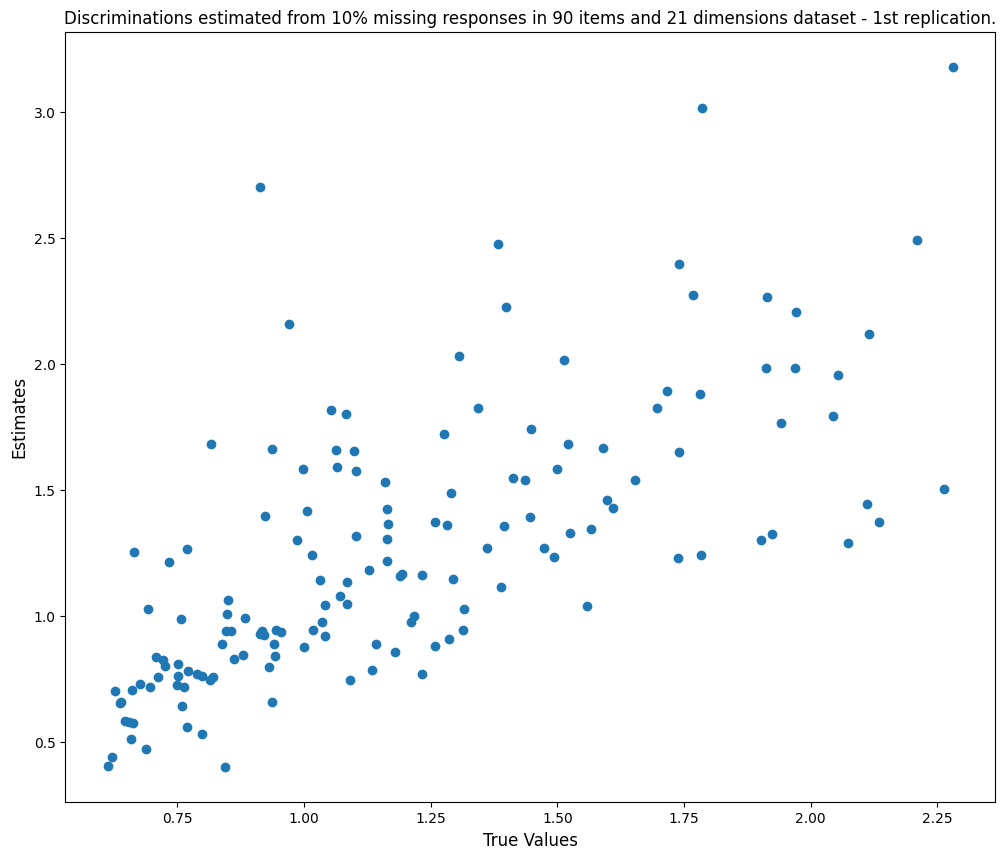

In [18]:
plt.figure(figsize=(12, 10))
plt.scatter(x=a_values, y=a_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Discriminations estimated from 10% missing responses in 90 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [19]:
a_results.to_csv('output_data/10_missing/a/a_results.csv', sep=';', header=True, index=False)

## Difficulties

In [20]:
cols = ['b_values']

b_results = pd.DataFrame(columns=cols)

b_results['b_values'] = b_values

b_results = pd.concat([b_results, diffs], axis=1)

In [21]:
b_results['Bias'] = np.sum(b_values.values - diffs.values, axis=1)/100
b_results['RMSE'] = np.sqrt(np.sum((b_values.values - diffs)**2, axis=1)/100)
b_results['Abs Bias'] = np.sum(np.abs(b_values.values - diffs.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/3793169349.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/3793169349.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/3793169349.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

In [22]:
corrs = []

for column in diffs:
    corrs.append(b_results['b_values'].corr(diffs[column]))

b_results['Corr'] = ""
b_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/713609593.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/713609593.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
b_results

,b_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,-1.194972,-1.096048,-1.145541,-1.170800,-1.137348,-1.174075,-1.121660,-1.155555,-1.121371,-1.209764,...,-1.158645,-1.149919,-1.176397,-1.107248,-1.136588,-1.193649,-0.045256,0.062695,0.052157,0.97328
1,1.404483,1.589213,1.667453,1.614229,1.610604,1.618403,1.622996,1.579912,1.556887,1.441944,...,1.524781,1.594038,1.490737,1.580911,1.596081,1.484474,-0.153994,0.163289,0.153994,
2,-1.196988,-1.323277,-1.314166,-1.371578,-1.297500,-1.194975,-1.210395,-1.398202,-1.477242,-1.462123,...,-1.348746,-1.320363,-1.376640,-1.438941,-1.394296,-1.347243,0.158660,0.179851,0.164728,
3,0.472191,0.928036,0.856039,0.758936,0.870493,0.664863,0.883578,0.906636,1.004367,0.794924,...,0.832909,0.798158,0.766370,0.850213,0.872629,0.945394,-0.374221,0.386084,0.374862,
4,1.783818,1.791843,1.882576,1.860980,1.779594,2.002720,1.809023,1.903043,1.846651,1.795679,...,1.331701,1.811147,1.830372,1.827110,1.903463,1.687708,-0.006786,0.097139,0.068168,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.527809,0.571392,0.455739,0.449022,0.362955,0.478514,0.462842,0.491036,0.393544,0.492387,...,0.532975,0.403158,0.362287,0.409237,0.469758,0.500017,0.054442,0.077812,0.066391,
86,-0.749307,-1.126409,-1.143139,-1.107219,-1.130736,-1.051581,-1.231987,-1.222617,-1.152491,-0.978385,...,-1.117068,-1.111758,-1.202864,-1.041933,-1.140119,-1.065607,0.344740,0.357623,0.344740,
87,0.163070,0.561733,0.477074,0.493641,0.421833,0.403463,0.417616,0.275168,0.407964,0.420338,...,0.579008,0.482825,0.499924,0.373519,0.417585,0.387561,-0.270240,0.281954,0.270240,
88,0.928725,1.198351,1.087773,1.015286,1.000661,1.052229,1.043852,0.940847,1.054050,1.036288,...,1.218485,1.121173,1.099960,1.119226,0.999449,1.014415,-0.140558,0.159761,0.142876,


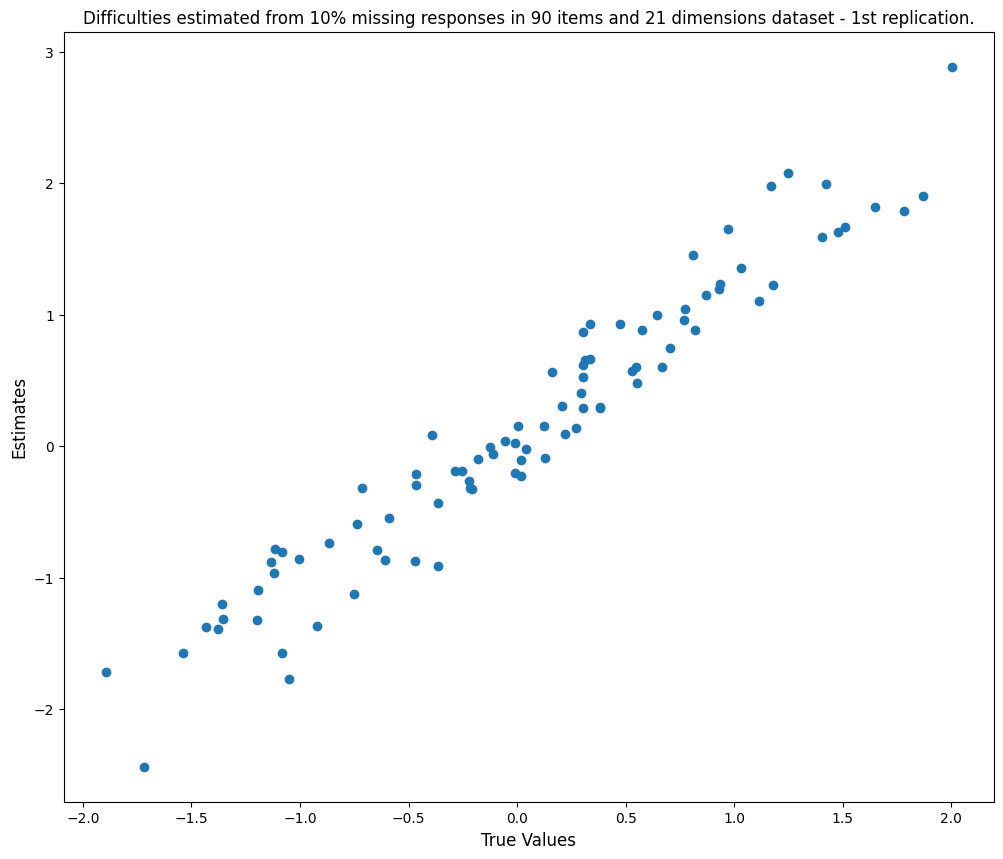

In [24]:
plt.figure(figsize=(12, 10))
plt.scatter(x=b_values, y=b_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Difficulties estimated from 10% missing responses in 90 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [25]:
b_results.to_csv('output_data/10_missing/b/b_results.csv', sep=';', header=True, index=False)

## Thetas

In [26]:
theta_values = theta_values.values.reshape((21, 10000))[:, :8000].flatten()

In [27]:
cols = ['theta_values']

theta_results = pd.DataFrame(columns=cols)

theta_results['theta_values'] = theta_values

theta_results = pd.concat([theta_results, thetas], axis=1)


In [28]:
theta_values = theta_values.reshape((theta_values.shape[0], 1))

In [29]:
theta_results['Bias'] = np.sum(theta_values - thetas.values, axis=1)/100
theta_results['RMSE'] = np.sqrt(np.sum((theta_values - thetas)**2, axis=1)/100)
theta_results['Abs Bias'] = np.sum(np.abs(theta_values - thetas.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/3674056909.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/3674056909.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/3674056909.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

In [30]:
corrs = []

for column in thetas:
    corrs.append(theta_results['theta_values'].corr(thetas[column]))

theta_results['Corr'] = ""
theta_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/2499224961.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_4967/2499224961.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
theta_results

,theta_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,-0.019225,-0.232534,-1.102717,0.173866,0.521237,0.599745,-0.225128,-0.616519,-0.013865,-0.369611,...,0.450943,1.774310,0.478487,1.183453,0.865578,1.265385,-0.158206,0.716984,0.567580,0.706479
1,-1.773350,-2.151523,-2.073326,-1.723263,-2.248097,-2.416620,-3.078399,-1.998929,-3.022990,-2.531595,...,-3.077670,-2.160730,-2.050905,-1.440779,-3.013650,-2.047663,0.782361,0.928472,0.813787,
2,-0.012759,0.923747,-0.580639,-0.580813,-0.541247,2.333509,1.194671,-0.038749,-0.443022,-0.299769,...,0.248339,0.146990,-0.323091,-0.120019,1.471752,1.181067,-0.101590,0.755947,0.574217,
3,0.032244,-0.212655,0.728366,0.864837,0.387174,0.607127,0.929846,1.329204,0.089498,-0.120771,...,1.820652,0.287484,0.261161,0.871550,1.037169,0.083945,-0.259036,0.701928,0.552441,
4,-0.712594,-1.144054,-1.763322,-1.917618,-1.686566,-1.746817,-1.518223,-1.657694,-0.593611,-0.669385,...,0.015716,-1.060737,-1.299659,-0.351894,-0.633150,-0.337230,0.552242,0.784009,0.650853,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167995,-0.702055,-0.919973,-0.133967,-1.473679,-0.505860,-0.249802,0.422451,-1.961881,-1.184397,-1.464978,...,-0.854636,-0.205936,-0.928728,-0.334950,1.038552,-1.116218,-0.019130,1.082386,0.885662,
167996,0.915393,0.995656,-0.228723,2.945780,1.717212,1.232034,1.116933,1.086545,2.393736,1.172290,...,2.673219,1.958614,0.897307,2.594198,0.702801,1.945937,-0.218114,0.824848,0.645100,
167997,-0.994150,-1.625575,-0.627425,-1.577631,-2.164009,1.496883,-2.521699,0.753634,2.515808,-0.447201,...,-2.888985,-2.049402,-1.304632,-1.453022,-1.106224,-1.265936,0.198080,1.086263,0.898424,
167998,1.004069,1.823402,0.917311,1.553534,0.442324,2.165255,1.651541,1.030065,0.650122,0.725376,...,1.354617,0.864661,0.420506,2.262968,1.481821,1.488323,-0.046276,0.649742,0.497859,


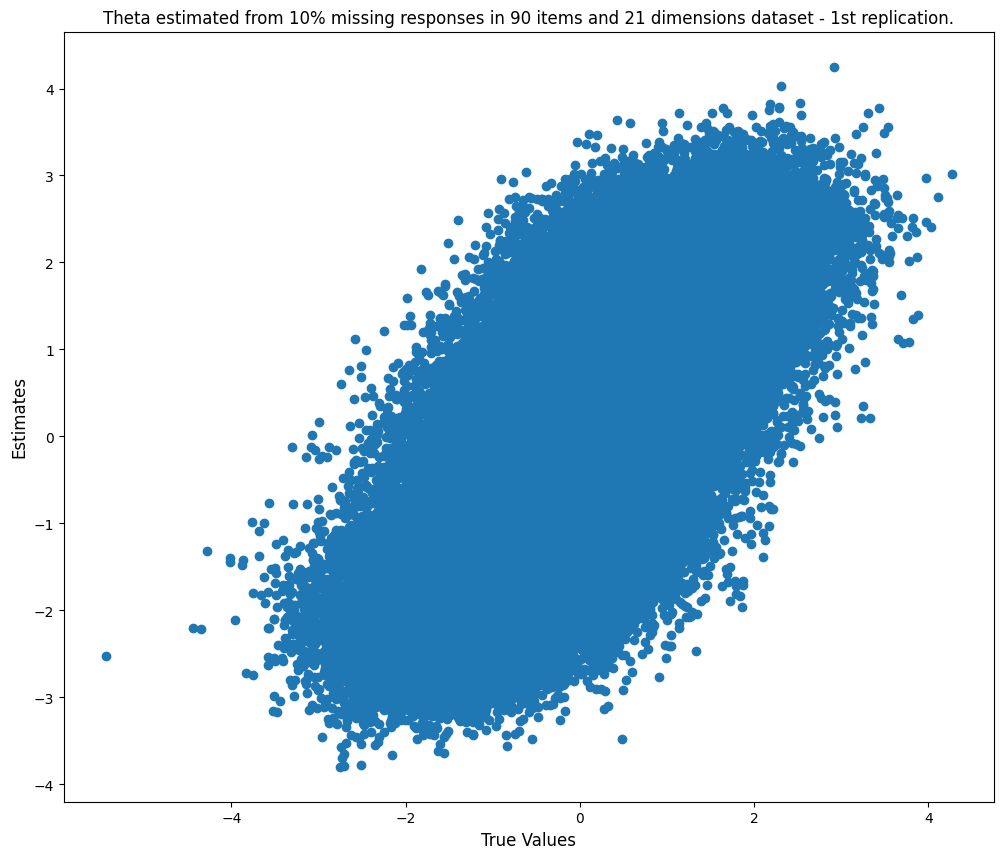

In [32]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=theta_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Theta estimated from 10% missing responses in 90 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [ ]:
theta_results.to_csv('output_data/10_missing/theta/theta_results.csv', sep=';', header=True, index=False)

In [ ]:
theta_df = pd.DataFrame()
theta_df['Estimate'] = thetas['Rep1']
theta_df['Dim'] = ""
theta_df['Dim'][:8000] = 1
theta_df['Dim'][8000:16000] = 2
theta_df['Dim'][16000:] = 3


In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=theta_df['Estimate'], c=theta_df['Dim'], cmap=plt.cm.Set1)
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

## Confusion Matrix

In [ ]:
def matrix_metrix(real_values, pred_values):
   CM = confusion_matrix(real_values, pred_values)
   TN = CM[0][0]
   FN = CM[1][0] 
   TP = CM[1][1]
   FP = CM[0][1]
   Population = TN+FN+TP+FP
   Accuracy   = round( (TP+TN) / Population,4)
   Precision  = round( TP / (TP+FP),4 )
   NPV        = round( TN / (TN+FN),4 )
   FDR        = round( FP / (TP+FP),4 )
   FOR        = round( FN / (TN+FN),4 ) 
   Recall     = round( TP / (TP+FN),4 )
   FPR        = round( FP / (TN+FP),4 )
   FNR        = round( FN / (TP+FN),4 )
   TNR        = round( TN / (TN+FP),4 ) 

   return {#'CM': CM, 
           'TN': TN,
           'FN': FN,
           'TP': TP,
           'FP': FP,
           'Population': Population,
           'Accuracy': Accuracy,
           'Precision': Precision,
           'NPV': NPV,
           'FDR': FDR,
           'FOR': FOR,
           'Recall': Recall,
           'FPR': FPR,
           'FNR': FNR,
           'TNR': TNR
           }

In [ ]:
print(confusion_matrix(np.array(originals[0]).flatten(), binary_preds['Rep1']))
skplt.metrics.plot_confusion_matrix(np.array(originals[0]).flatten(), binary_preds['Rep1'],figsize=(8,8))

In [ ]:
res = matrix_metrix(np.array(originals[0]).flatten(), binary_preds['Rep1'])

df = pd.DataFrame({'Metric': res.keys(), 'Value': res.values()})

print(df)

In [ ]:
fpr, tpr, thresholds = roc_curve(np.array(originals[0]).flatten(), preds['Rep1'])
auc = roc_auc_score(np.array(originals[0]).flatten(), preds['Rep1'])
print('AUC: %.3f' % auc)

plt.plot(fpr, tpr, linestyle='--', label='Roc curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(np.array(originals[0]).flatten(), preds['Rep1'])

plt.plot(recall, precision, linestyle='--', label='Precision versus Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Charts

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=thetas[0]['Thetas Estimation'])
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

In [ ]:
print(b_values.shape)
print(negative_diff.shape)

In [ ]:


fig_a = go.Figure()
fig_a.add_trace(go.Scatter(y=discr_hat, mode='lines', name='Python'))
fig_a.add_trace(go.Scatter(y=a_values.iloc[:,0], mode='lines', name='a Real'))
fig_a.update_layout( title="Discrimation")
fig_a.show()

fig_b = go.Figure()
fig_b.add_trace(go.Scatter(y=negative_diff.iloc[:,0], mode='lines', name='Python'))
fig_b.add_trace(go.Scatter(y=b_values.iloc[:,0], mode='lines', name='b Real'))
fig_b.update_layout(title="Difficulty")
fig_b.show()

fig_theta = go.Figure()
#fig_theta.add_trace(go.Scatter(y=theta_rep_gui['Thetas Estimation'], mode='lines', name='Python'))
fig_theta.add_trace(go.Scatter(y=theta_values.iloc[:,0], mode='lines', name='Real'))
fig_theta.update_layout( title="Theta Real")
fig_theta.show()

fig_t = go.Figure()
fig_t.add_trace(go.Scatter(y=theta_rep_gui['Thetas Estimation'], line=dict(color='green',), mode='lines', name='Python'))
#fig_t.add_trace(go.Scatter(y=theta_rep['Thetas_est'], line=dict(color='green',),mode='lines', name='R'))
fig_t.update_layout( title="Theta Hat Python")
fig_t.show()



In [ ]:
theta_values = theta_values.values.reshape((21, 10000)).transpose()

In [ ]:
print(theta_hat.shape)
print(theta_values[:N, :].flatten().shape)

In [ ]:
print(len(discr))

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values[:N, :].flatten(), y=thetas_hat)
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

In [ ]:
len(discr_hat)

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=a_values, y=discr_hat)
#plt.colorbar()
plt.xlabel("True Values of a_values")
plt.ylabel("Estimates")
plt.show()


In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=b_values.values.flatten(), y=negative_diff)
#plt.colorbar()
plt.xlabel("True Values of b_values")
plt.ylabel("Estimates")
plt.show()